In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

In [2]:
file_path = "Task1_Analyze.xlsx"
xls = pd.ExcelFile(file_path)

# Interactive visualization

In [3]:
# Load the Excel file
file_path = "Task1_Analyze.xlsx"
xls = pd.ExcelFile(file_path)

# Load and filter metadata to include only valid countries (those with both Region and IncomeGroup)
df_meta = pd.read_excel(xls, sheet_name='Meta-POPLN')
df_meta = df_meta.rename(columns={"TableName": "Country"})
df_meta_valid = df_meta.dropna(subset=["Region", "IncomeGroup"])[["Country", "Country Code", "Region", "IncomeGroup"]]

# Load and process population data
df_population = pd.read_excel(xls, sheet_name='Data-POPLN', skiprows=3)
df_population = df_population.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})
df_population = df_population.drop(columns=["Indicator Name", "Indicator Code"])
df_population = df_population.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Population")
df_population["Year"] = df_population["Year"].astype(int)
df_population = df_population.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")

# Load and process health expenditure data
df_health_expenditure = pd.read_excel(xls, sheet_name='Data-HLTHEXPNDITURE', skiprows=3)
df_health_expenditure.columns = df_health_expenditure.iloc[0]
df_health_expenditure = df_health_expenditure[1:].reset_index(drop=True)
df_health_expenditure = df_health_expenditure.dropna(axis=1, how="all")
df_health_expenditure = df_health_expenditure.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})

df_health_expenditure = df_health_expenditure.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Health Expenditure (%)")
df_health_expenditure = df_health_expenditure[~df_health_expenditure["Year"].isin(["Series Name", "Series Code"])]
df_health_expenditure["Year"] = df_health_expenditure["Year"].str.extract(r"(\d{4})").astype(int)
df_health_expenditure["Health Expenditure (%)"] = pd.to_numeric(df_health_expenditure["Health Expenditure (%)"], errors='coerce')
df_health_expenditure = df_health_expenditure.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")
df_combined = df_health_expenditure.merge(df_population, on=["Country", "Country Code", "Year", "Region", "IncomeGroup"], how="inner")

# Compute global average health expenditure
world_avg = df_combined.groupby("Year")["Health Expenditure (%)"].mean().reset_index()

# Compute region-wise average health expenditure
region_avg = df_combined.groupby(["Region", "Year"])["Health Expenditure (%)"].mean().reset_index()

# Compute income group-wise average health expenditure
income_avg = df_combined.groupby(["IncomeGroup", "Year"])["Health Expenditure (%)"].mean().reset_index()

# Select the top 5, 10, and 20 most populated countries (based on 2015 data)
df_population_2015 = df_combined[df_combined["Year"] == 2015]
top_5_countries = df_population_2015.nlargest(5, "Population")["Country"].tolist()
top_10_countries = df_population_2015.nlargest(10, "Population")["Country"].tolist()
top_20_countries = df_population_2015.nlargest(20, "Population")["Country"].tolist()

df_top5 = df_combined[df_combined["Country"].isin(top_5_countries)]
df_top10 = df_combined[df_combined["Country"].isin(top_10_countries)]
df_top20 = df_combined[df_combined["Country"].isin(top_20_countries)]

# Get the list of all available countries
all_countries = df_combined["Country"].unique()

# Initialize JupyterDash app
app = JupyterDash(__name__)

# Define the layout of the app
app.layout = html.Div([
    # Dropdown for selecting the chart type
    dcc.Dropdown(
        id='chart-selector',
        options=[
            {'label': 'Global Average', 'value': 'global'},
            {'label': 'Region-wise', 'value': 'region'},
            {'label': 'Income Group-wise', 'value': 'income'},
            {'label': 'Top 5 Populated Countries', 'value': 'top5'},
            {'label': 'Top 10 Populated Countries', 'value': 'top10'},
            {'label': 'Top 20 Populated Countries', 'value': 'top20'},
            {'label': 'Custom Countries', 'value': 'custom'}
        ],
        value='global',
        clearable=False
    ),

    # Dropdown for selecting custom countries (hidden by default)
    dcc.Dropdown(
        id='custom-country-selector',
        options=[{'label': country, 'value': country} for country in all_countries],
        multi=True,
        placeholder="Select countries...",
        style={'display': 'none'}  # Initially hidden
    ),

    # Graph to display selected data
    dcc.Graph(id='graph-output')
])

# Show the country selection dropdown only when "Custom Countries" is selected
@app.callback(
    Output('custom-country-selector', 'style'),
    [Input('chart-selector', 'value')]
)
def toggle_custom_dropdown(selected_chart):
    """Show the country selector only when 'Custom Countries' is selected"""
    return {'display': 'block'} if selected_chart == 'custom' else {'display': 'none'}

# Update the graph based on the selected chart type
@app.callback(
    Output('graph-output', 'figure'),
    [Input('chart-selector', 'value'),
     Input('custom-country-selector', 'value')]
)
def update_graph(selected_chart, selected_countries):
    """Update the graph based on user selection"""
    if selected_chart == 'global':
        fig = px.line(world_avg, x='Year', y='Health Expenditure (%)', title='Global Average Government Health Expenditure (%)')
    
    elif selected_chart == 'region':
        fig = px.line(region_avg, x='Year', y='Health Expenditure (%)', color='Region', title='Region-wise Government Health Expenditure (%)')
    
    elif selected_chart == 'income':
        fig = px.line(income_avg, x='Year', y='Health Expenditure (%)', color='IncomeGroup', title='Income Group-wise Government Health Expenditure (%)')
    
    elif selected_chart == 'top5':
        fig = px.line(df_top5, x='Year', y='Health Expenditure (%)', color='Country', title='Top 5 Most Populated Countries - Health Expenditure (%)')
    
    elif selected_chart == 'top10':
        fig = px.line(df_top10, x='Year', y='Health Expenditure (%)', color='Country', title='Top 10 Most Populated Countries - Health Expenditure (%)')
    
    elif selected_chart == 'top20':
        fig = px.line(df_top20, x='Year', y='Health Expenditure (%)', color='Country', title='Top 20 Most Populated Countries - Health Expenditure (%)')

    elif selected_chart == 'custom' and selected_countries:
        df_custom = df_combined[df_combined["Country"].isin(selected_countries)]
        fig = px.line(df_custom, x='Year', y='Health Expenditure (%)', color='Country', title='Custom Selected Countries - Health Expenditure (%)')
    else:
        fig = px.line(title="Select at least one country")
    
    return fig

# Run the app inside Jupyter Notebook
app.run_server(mode="external", debug=False)



Dash app running on http://127.0.0.1:8050/


In [4]:
fig = px.line(world_avg, x='Year', y='Health Expenditure (%)', title='Global Average Government Health Expenditure (%)')
fig.write_html("Task2.html")

# Static Visualization

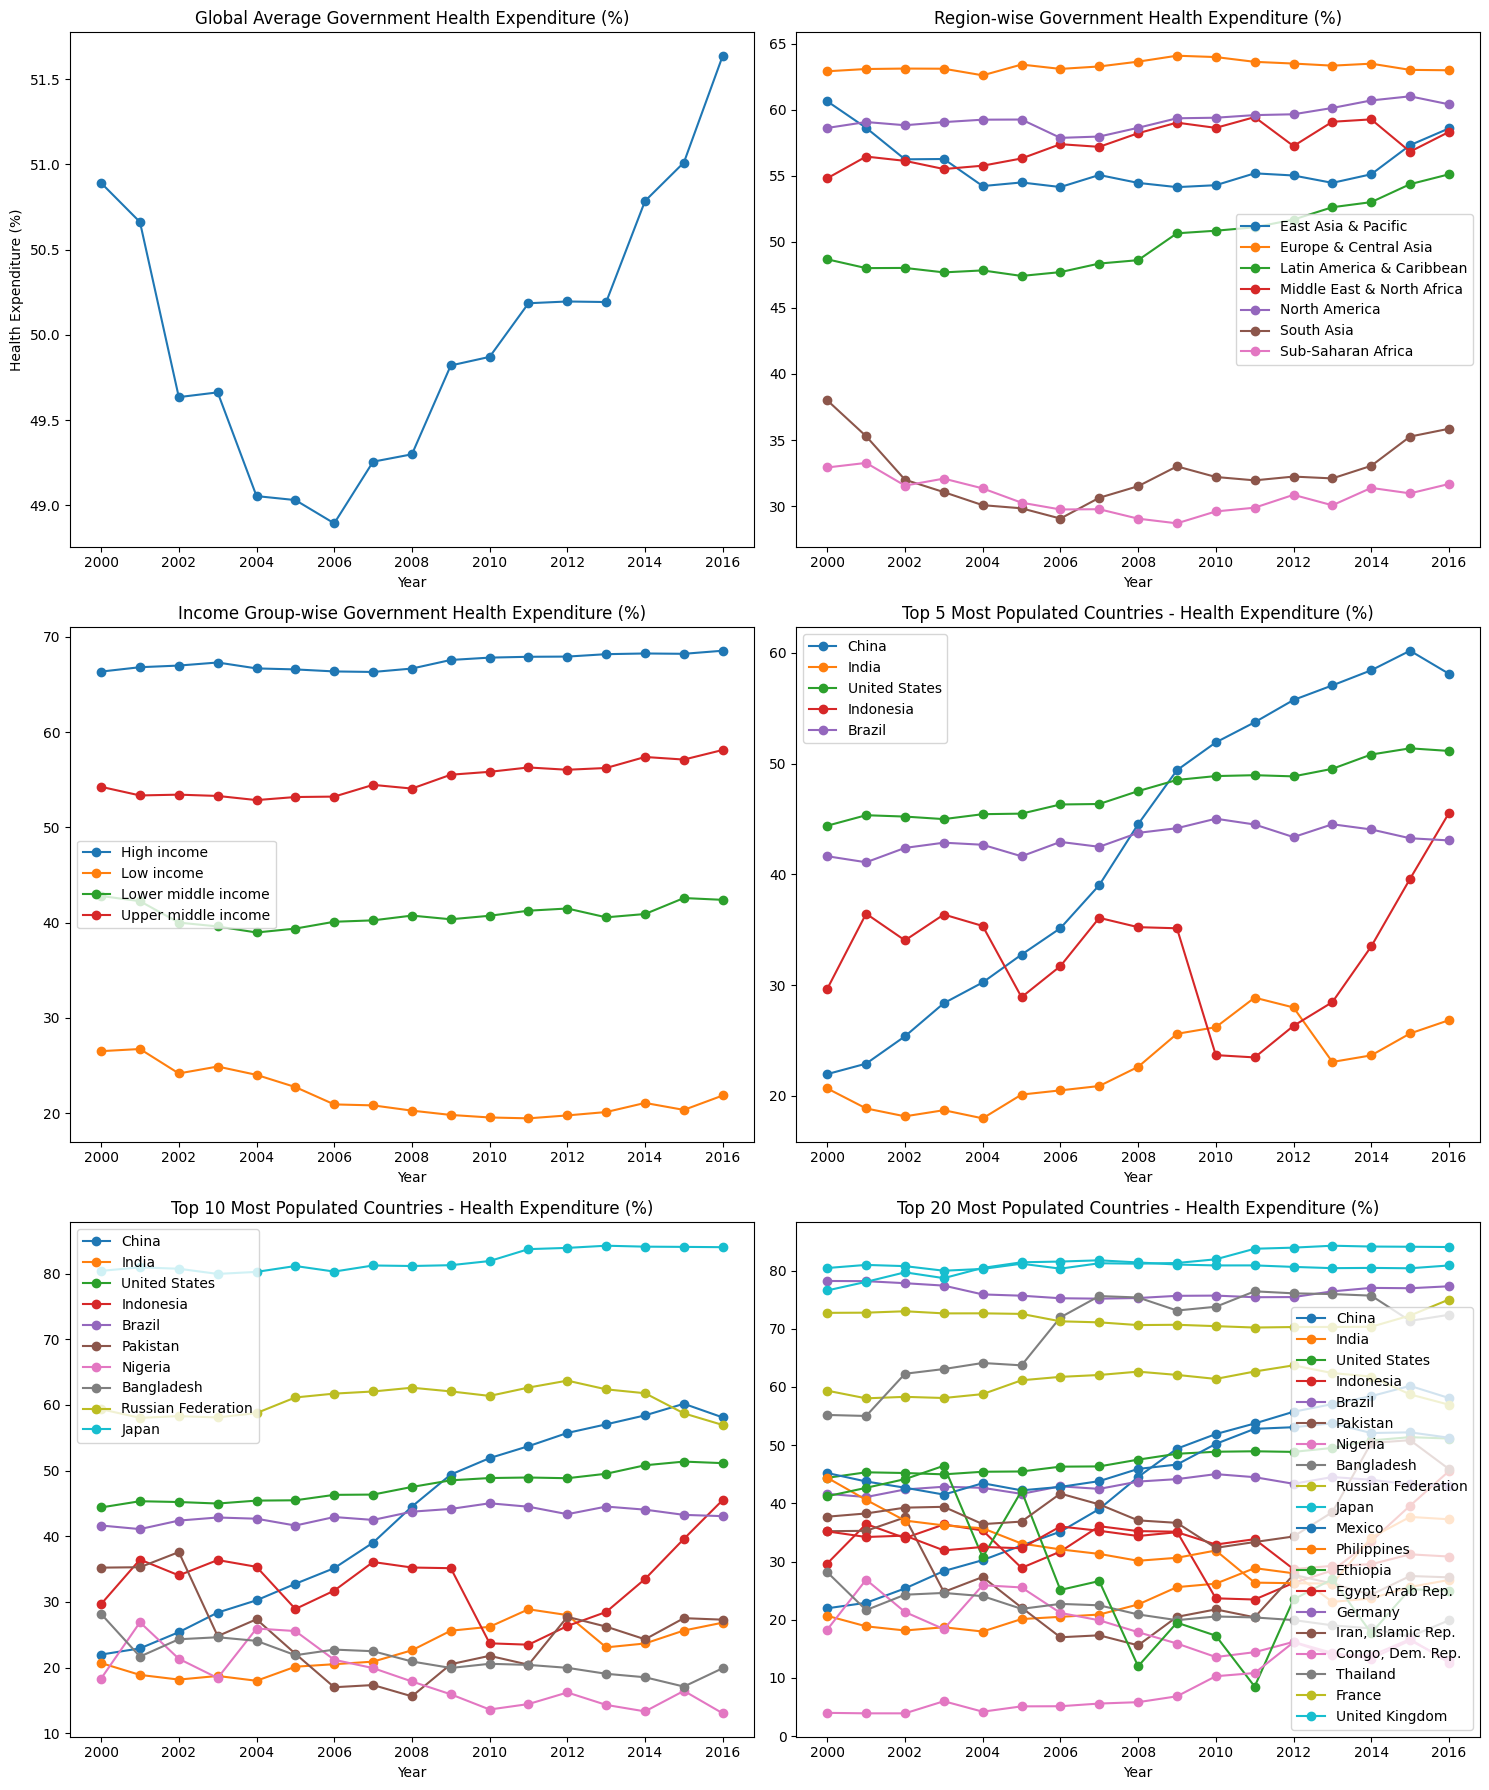

In [ ]:
# Reload and filter metadata to include only valid countries (those with both Region and IncomeGroup)
df_meta = pd.read_excel(xls, sheet_name='Meta-POPLN')
df_meta = df_meta.rename(columns={"TableName": "Country"})
df_meta_valid = df_meta.dropna(subset=["Region", "IncomeGroup"])[["Country", "Country Code", "Region", "IncomeGroup"]]

# Load and filter population data to include only valid countries
df_population = pd.read_excel(xls, sheet_name='Data-POPLN', skiprows=3)
df_population = df_population.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})
df_population = df_population.drop(columns=["Indicator Name", "Indicator Code"])
df_population = df_population.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Population")
df_population["Year"] = df_population["Year"].astype(int)

# Merge population data with valid country metadata
df_population = df_population.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")

# Load and clean health expenditure data
df_health_expenditure = pd.read_excel(xls, sheet_name='Data-HLTHEXPNDITURE', skiprows=3)
df_health_expenditure.columns = df_health_expenditure.iloc[0]
df_health_expenditure = df_health_expenditure[1:].reset_index(drop=True)
df_health_expenditure = df_health_expenditure.dropna(axis=1, how="all")
df_health_expenditure = df_health_expenditure.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})

# Reshape health expenditure data
df_health_expenditure = df_health_expenditure.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Health Expenditure (%)")
df_health_expenditure = df_health_expenditure[~df_health_expenditure["Year"].isin(["Series Name", "Series Code"])]
df_health_expenditure["Year"] = df_health_expenditure["Year"].str.extract(r"(\d{4})").astype(int)
df_health_expenditure["Health Expenditure (%)"] = pd.to_numeric(df_health_expenditure["Health Expenditure (%)"], errors='coerce')

# Merge health expenditure data with valid country metadata
df_health_expenditure = df_health_expenditure.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")

# Merge health expenditure with population data
df_combined = df_health_expenditure.merge(df_population, on=["Country", "Country Code", "Year", "Region", "IncomeGroup"], how="inner")

# Compute world average health expenditure
world_avg = df_combined.groupby("Year")["Health Expenditure (%)"].mean()

# Compute region-wise average health expenditure
region_avg = df_combined.groupby(["Region", "Year"])["Health Expenditure (%)"].mean().reset_index()

# Compute income group-wise average health expenditure
income_avg = df_combined.groupby(["IncomeGroup", "Year"])["Health Expenditure (%)"].mean().reset_index()

# Select top 5, 10, 20 most populated countries in 2015 from valid dataset
df_population_2015 = df_combined[df_combined["Year"] == 2015]
top_5_countries = df_population_2015.nlargest(5, "Population")["Country"].tolist()
top_10_countries = df_population_2015.nlargest(10, "Population")["Country"].tolist()
top_20_countries = df_population_2015.nlargest(20, "Population")["Country"].tolist()

# Filter health expenditure for these countries
df_top5 = df_combined[df_combined["Country"].isin(top_5_countries)]
df_top10 = df_combined[df_combined["Country"].isin(top_10_countries)]
df_top20 = df_combined[df_combined["Country"].isin(top_20_countries)]

# Generate and display corrected plots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Global average trend
axes[0, 0].plot(world_avg.index, world_avg.values, marker='o', linestyle='-')
axes[0, 0].set_title("Global Average Government Health Expenditure (%)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Health Expenditure (%)")

# Region-wise trend
for region in region_avg["Region"].unique():
    subset = region_avg[region_avg["Region"] == region]
    axes[0, 1].plot(subset["Year"], subset["Health Expenditure (%)"], marker='o', linestyle='-', label=region)
axes[0, 1].set_title("Region-wise Government Health Expenditure (%)")
axes[0, 1].set_xlabel("Year")
axes[0, 1].legend()

# Income group-wise trend
for income_group in income_avg["IncomeGroup"].unique():
    subset = income_avg[income_avg["IncomeGroup"] == income_group]
    axes[1, 0].plot(subset["Year"], subset["Health Expenditure (%)"], marker='o', linestyle='-', label=income_group)
axes[1, 0].set_title("Income Group-wise Government Health Expenditure (%)")
axes[1, 0].set_xlabel("Year")
axes[1, 0].legend()

# Top 5 most populated countries (corrected)
for country in top_5_countries:
    subset = df_top5[df_top5["Country"] == country]
    axes[1, 1].plot(subset["Year"], subset["Health Expenditure (%)"], marker='o', linestyle='-', label=country)
axes[1, 1].set_title("Top 5 Most Populated Countries - Health Expenditure (%)")
axes[1, 1].set_xlabel("Year")
axes[1, 1].legend()

# Top 10 most populated countries (corrected)
for country in top_10_countries:
    subset = df_top10[df_top10["Country"] == country]
    axes[2, 0].plot(subset["Year"], subset["Health Expenditure (%)"], marker='o', linestyle='-', label=country)
axes[2, 0].set_title("Top 10 Most Populated Countries - Health Expenditure (%)")
axes[2, 0].set_xlabel("Year")
axes[2, 0].legend()

# Top 20 most populated countries (corrected)
for country in top_20_countries:
    subset = df_top20[df_top20["Country"] == country]
    axes[2, 1].plot(subset["Year"], subset["Health Expenditure (%)"], marker='o', linestyle='-', label=country)
axes[2, 1].set_title("Top 20 Most Populated Countries - Health Expenditure (%)")
axes[2, 1].set_xlabel("Year")
axes[2, 1].legend()

plt.tight_layout()

plt.savefig("Task2_Static.png", dpi=1200, bbox_inches='tight')
plt.show()


# Insights

Global government health expenditure declined from 2000 to 2006 but increased steadily afterward. North America and Europe had the highest spending, while Sub-Saharan Africa and South Asia remained low. High-income countries consistently invested more, whereas low-income nations showed minimal growth. China and India increased spending, while the U.S. remained stable. Among the top 10 and 20 most populated countries, developed nations like Japan and Germany had high expenditure, while Nigeria, Bangladesh, and Ethiopia lagged. These trends highlight persistent global disparities in public health funding, with wealthier regions prioritizing investment while lower-income countries struggle to increase spending.

# Statistical analysis

In [5]:
import statsmodels.api as sm
# Load metadata and filter valid countries
df_meta = pd.read_excel(xls, sheet_name='Meta-POPLN')
df_meta = df_meta.rename(columns={"TableName": "Country"})
df_meta_valid = df_meta.dropna(subset=["Region", "IncomeGroup"])[["Country", "Country Code", "Region", "IncomeGroup"]]

# Load and filter population data
df_population = pd.read_excel(xls, sheet_name='Data-POPLN', skiprows=3)
df_population = df_population.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})
df_population = df_population.drop(columns=["Indicator Name", "Indicator Code"])
df_population = df_population.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Population")
df_population["Year"] = df_population["Year"].astype(int)
df_population = df_population.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")

# Load and filter health expenditure data
df_health_expenditure = pd.read_excel(xls, sheet_name='Data-HLTHEXPNDITURE', skiprows=3)
df_health_expenditure.columns = df_health_expenditure.iloc[0]
df_health_expenditure = df_health_expenditure[1:].reset_index(drop=True)
df_health_expenditure = df_health_expenditure.dropna(axis=1, how="all")
df_health_expenditure = df_health_expenditure.rename(columns={"Country Name": "Country", "Country Code": "Country Code"})
df_health_expenditure = df_health_expenditure.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="Health Expenditure (%)")
df_health_expenditure = df_health_expenditure[~df_health_expenditure["Year"].isin(["Series Name", "Series Code"])]
df_health_expenditure["Year"] = df_health_expenditure["Year"].str.extract(r"(\d{4})").astype(int)
df_health_expenditure["Health Expenditure (%)"] = pd.to_numeric(df_health_expenditure["Health Expenditure (%)"], errors='coerce')
df_health_expenditure = df_health_expenditure.merge(df_meta_valid, on=["Country", "Country Code"], how="inner")

# Merge datasets
df_combined = df_health_expenditure.merge(df_population, on=["Country", "Country Code", "Year", "Region", "IncomeGroup"], how="inner")

# Compute population growth rate for each country
df_combined["Population Growth Rate"] = df_combined.groupby("Country")["Population"].pct_change() * 100

# Compute government health expenditure growth rate for each country
df_combined["Health Expenditure Growth Rate"] = df_combined.groupby("Country")["Health Expenditure (%)"].pct_change() * 100

# Drop NaN values after computing growth rates
df_growth = df_combined.dropna(subset=["Population Growth Rate", "Health Expenditure Growth Rate"])

# Perform linear regression (OLS) to fit the relationship
X = df_growth["Population Growth Rate"]
y = df_growth["Health Expenditure Growth Rate"]

# Add a constant for the regression model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Display regression results
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Health Expenditure Growth Rate   R-squared:                       0.003
Model:                                        OLS   Adj. R-squared:                  0.002
Method:                             Least Squares   F-statistic:                     7.643
Date:                            Fri, 07 Mar 2025   Prob (F-statistic):            0.00574
Time:                                    03:34:25   Log-Likelihood:                -12806.
No. Observations:                            2883   AIC:                         2.562e+04
Df Residuals:                                2881   BIC:                         2.563e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3918      0.527      0.743      0.457      -0.642       1.425
Population Growth Rate     0.6586      0.238      2.765      0.006       0.191       1.126
==============================================================================
Omnibus:                     5832.259   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31670859.644
Skew:                          16.025   Prob(JB):                         0.00
Kurtosis:                     515.467   Cond. No.                         3.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Statistical insights

The OLS regression results indicate a weak relationship between population growth rate and health expenditure growth rate, with an R-squared value of 0.003, meaning only 0.3% of the variance in health expenditure growth is explained by population growth. The coefficient for population growth rate is 0.6586, suggesting a slight positive effect, and the p-value of 0.006 indicates statistical significance. However, the model's overall explanatory power is very low. The intercept (0.3918) is not significant (p = 0.457). The high skewness (16.025) and extreme kurtosis (515.467) indicate non-normal residuals, suggesting potential data issues or the need for a better model.